# (Project) Use VAE to learn from real data, then create use the model to create realistic synthetic data
- keywords: learned joint distribution
- **VAE model learn pattern of a variables as a whole and capture any correlation/pattern between variables**. VAE learn a joint distribution of the input data, capturing the underlying structure and correlations among variables. Probabilistic distribution from decoder is a single joint distribution that encompasses all the variables. It does not model each variable with a separate distribution in isolation; rather, it learns a single, complex probability distribution that captures the correlations and patterns among all the variables. 
- VAEs can also be adapted for time series data. Coupling VAEs with RNNs or 1D CNNs can make them more suitable for capturing temporal relationships in data.
- Conditional VAEs can be used to generate data that is conditioned on past values or other series, preserving temporal correlations.

### What is stochastic process?
- lets say our stochastic process is normal distribution with mean of 0.1 and variance of 0.05. We start with value of 100. First samples of distribution is 0.1, hence 100* (1+0.1) = 110, second sample is -0.05, hence 110* (1+-0.05) and so on
- This is a simple example of a random walk process, where the value can randomly move up or down based on the sampled values from the normal distribution.

- VAEs and GANs are deep learning models thatare more specialized than basic ANNs and are specifically designed for generative tasks, whereas RNNs and LSTMs are focused on sequential data processing, such as time series analysis or natural language processing.

### Variational Autoencoder (VAE)
- - usage case: learn data generation
- **(How VAE Works)** consists of two main parts: an encoder and a decoder
    - encoder compresses the input data into a latent (hidden) space representation, outputs parameters (mean and variance) of a **probability distribution** representing the data. **VAE assume input data is multivariate Gaussian/Normal distribution**, the mean and variance is used by decoder to create a stochastic process
    - decoder then reconstructs the input data from this **probabilistic representation** 
    
### Generative Adversarial Network (GAN)
- **(How GAN Works)** consists of two networks: a generator and a discriminator. Generator creates data intended to pass as real, while the discriminator evaluates whether the data it receives is real (from the dataset) or fake (from the generator). The two networks are trained simultaneously in a game-theoretic scenario where the generator aims to produce increasingly convincing data, and the discriminator aims to become better at distinguishing real data from fake.

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed



import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


In [6]:
df = pd.read_excel('Macro_Data2.xlsx')
df = df.ffill().bfill()

In [13]:
df

,Date,DXY,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds
0,2023-02-03,102.919998,4136.48,1864.97,102.915,3.5246
1,2023-02-05,102.919998,4111.08,1867.48,103.621,3.6399
2,2023-02-06,103.620003,4164.00,1873.10,103.427,3.6735
3,2023-02-07,103.430000,4117.86,1875.49,103.409,3.6098
4,2023-02-08,103.410004,4081.50,1861.78,103.221,3.6579
...,...,...,...,...,...,...
180,2023-09-08,105.089996,4327.78,1932.82,106.648,4.6124
181,2023-09-10,105.089996,4373.63,1920.20,106.243,4.7060
182,2023-09-11,104.570000,4373.20,1923.18,106.250,4.8341
183,2023-09-12,104.709999,4314.60,1947.55,106.565,4.9149


In [74]:
# df = df.drop(['Date'], axis=1)

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Split the data (in this case, we're not splitting since it's unsupervised learning, but you might for validation)
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)

In [75]:
time_steps = 10  # This is an arbitrary choice for illustration

# Function to create a 3D array from 2D array of time series data
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)

# Create sequences for training and testing sets
X_train = create_sequences(X_train, time_steps)
X_test = create_sequences(X_test, time_steps)

In [76]:
X_train.shape

(139, 10, 5)

# Building the VAE Model
- encoder layer: takes input data and map it into a lower-dimension latent space that is characterized by a mean (z_mean) and a logarithm of variance (z_log_var) for each data point. The encoder's job is to learn how to represent the input data in this latent space in a way that preserves the essential characteristics of the data.
- Z layer: use the mean and variance from encoder layer (pluss an epislon for error) to create a sample from a learned probabilistic distribution. z layer create samples from probabilistic distribution and feed into decoder
- decoder layer: The decoder network takes the sampled point z as input and processes it through a series of layers, typically using activation functions like ReLU or sigmoid. The final layer of the decoder produces synthetic data points which should ideally resemble the original input data. This process of sampling from z and passing it through the decoder can be repeated multiple times to generate multiple synthetic data samples.

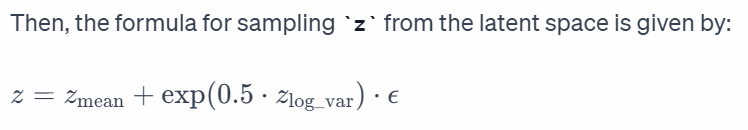
- z_mean: The mean of the latent space, which determines the center point around which samples are generated.
- z_log_var: The logarithm of the variance of the latent space, which represents how spread out or uncertain the samples should be.
- epsilon: Random samples drawn from a standard normal distribution, introducing the stochastic element into the sampling process.

In [83]:
original_dim = X_train.shape[2]
input_shape = (time_steps, original_dim)
intermediate_dim = 64
latent_dim = 2

# Encoder with LSTM
inputs = Input(shape=input_shape, name='encoder_input')
encoded = LSTM(intermediate_dim)(inputs)
z_mean = Dense(latent_dim, name='z_mean')(encoded)
z_log_var = Dense(latent_dim, name='z_log_var')(encoded)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Lambda: This is a layer constructor in Keras that allows you to wrap an arbitrary function or operation and use it as a layer within a Keras model
# It takes z_mean and z_log_var as input arguments and generates samples from the latent space.
# output_shape=(latent_dim,): This specifies the shape of the output produced by the Lambda layer
# name='z': This sets the name of the layer to 'z'.
# [z_mean, z_log_var]: These are the input tensors to the Lambda layer, and they are passed as a list to the Lambda layer. 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = RepeatVector(time_steps)(latent_inputs)  # Set the number of time steps to repeat

######### About VAE's loss function ############
# the loss function for the VAE consists of a reconstruction loss, which 
# measures how well the model reconstructs input data, and a KL divergence 
# loss, which encourages the latent space to follow a desired distribution.
# These two terms are combined to create the overall VAE loss, which is 
# used during training to optimize the model's parameters.

# Decoder with LSTM layers
decoder_h = LSTM(intermediate_dim, return_sequences=True)(x)  # Use LSTM and return sequences
outputs = TimeDistributed(Dense(original_dim))(decoder_h)  # Apply Dense to each time step

# Instantiate encoder and decoder models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs)) # measures how well the VAE can reconstruct the input data.
reconstruction_loss *= time_steps * original_dim  # adjusting the scale of the reconstruction loss to make it comparable in magnitude to the KL divergence loss, so that the 2 loss components contribute approximately equally to the overall VAE loss.

# KL Divergence Loss (kl_loss) measures how well the learned latent space distribution matches a predefined standard normal distribution (multivariate Gaussian distribution). It quantifies the discrepancy between the learned distribution and the desired distribution
# This encourages the latent space to follow a predefined distribution, typically a multivariate Gaussian distribution. 
#  Kullback-Leibler (KL) divergence term
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # computes the KL divergence term for each sample in the batch.
kl_loss = K.sum(kl_loss, axis=-1) # sums up the KL divergence term over all dimensions.
kl_loss *= -0.5 # negative 0.5 scaling factor is applied to make it consistent with the definition of KL divergence loss for Gaussian distributions.
vae_loss = K.mean(reconstruction_loss + kl_loss) # computes the final VAE loss by taking the mean of the sum of the reconstruction loss and the KL divergence loss. It balances the importance of these two components.
vae.add_loss(vae_loss) # This adds the vae_loss to the VAE model as an additional loss term to be optimized during training.

# without early stopping, the final model used is always the last epoch which may not be the model with the best validation loss
# early stopping chose the model/epoch with the best validation model when there is no improvement of validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

vae.compile(optimizer='adam')
#################################################

# Training the Model

In [84]:
vae.fit(X_train, X_train, epochs=1000, batch_size=32, validation_data=(X_test, X_test), callbacks=[early_stopping])


Epoch 1/1000
5/5 [==============================] - 5s 232ms/step - loss: 48.9608 - val_loss: 54.8857
Epoch 2/1000
5/5 [==============================] - 0s 15ms/step - loss: 47.8572 - val_loss: 54.5649
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 47.4785 - val_loss: 54.6785
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 48.2339 - val_loss: 54.7413
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 48.2183 - val_loss: 54.6823
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 47.9031 - val_loss: 54.9522
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 47.2700 - val_loss: 54.6713
Epoch 8/1000
5/5 [==============================] - 0s 15ms/step - loss: 47.4462 - val_loss: 54.7238
Epoch 9/1000
5/5 [==============================] - 0s 15ms/step - loss: 47.2647 - val_loss: 54.5456
Epoch 10/1000
5/5 [==============================] - 0s 14ms/step - loss: 48.0540 - val_lo

- 'loss' is 'training loss': it is the VAE loss function during training phase
- 'val_loss' (Validation Loss)

# Using the model to generate synthetic data

In [94]:
# generates synthetic data points using the trained 'decoder' layer
# of the 'vae' VAE model

# when time step =10, we are using 10 days data to predict the 11th day

def generate_next_day_prediction(n_samples, seed):
    np.random.seed(seed)
    # Sample from the latent space
    z_sample = np.random.normal(size=(n_samples, latent_dim))
    # Generate synthetic data
    synthetic_sequences = decoder.predict(z_sample)
    # Take the last time step from each sequence as the next day's prediction
    next_day_predictions = synthetic_sequences[:, -1, :]
    # Inverse transform to return to original data space
    next_day_predictions = scaler.inverse_transform(next_day_predictions)
    return next_day_predictions

# Generate predictions for the next day
n_samples = 10000  # Number of prediction sequences you want to generate
next_day_predictions = generate_next_day_prediction(n_samples, 0)

313/313 [==============================] - 1s 2ms/step


In [99]:
next_day_predictions.shape

(10000, 5)

In [101]:
synthetic_df = pd.DataFrame(next_day_predictions, columns=df.columns)

In [102]:
synthetic_df

,DXY,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds
0,103.343933,4244.813477,1899.101562,104.069077,4.015913
1,102.881355,4269.322754,1910.553833,104.131073,4.048913
2,103.465462,4232.164062,1899.577759,104.005882,3.994407
3,103.125671,4256.401367,1912.012695,103.774742,3.970879
4,102.820221,4282.490723,1930.656128,103.434776,3.923689
...,...,...,...,...,...
9995,103.096931,4250.021484,1902.025024,104.267441,4.056229
9996,102.607933,4294.491211,1922.702515,103.935455,4.026706
9997,102.702332,4289.324219,1949.083740,103.047920,3.843128
9998,102.844246,4276.384766,1932.140381,103.383133,3.904343


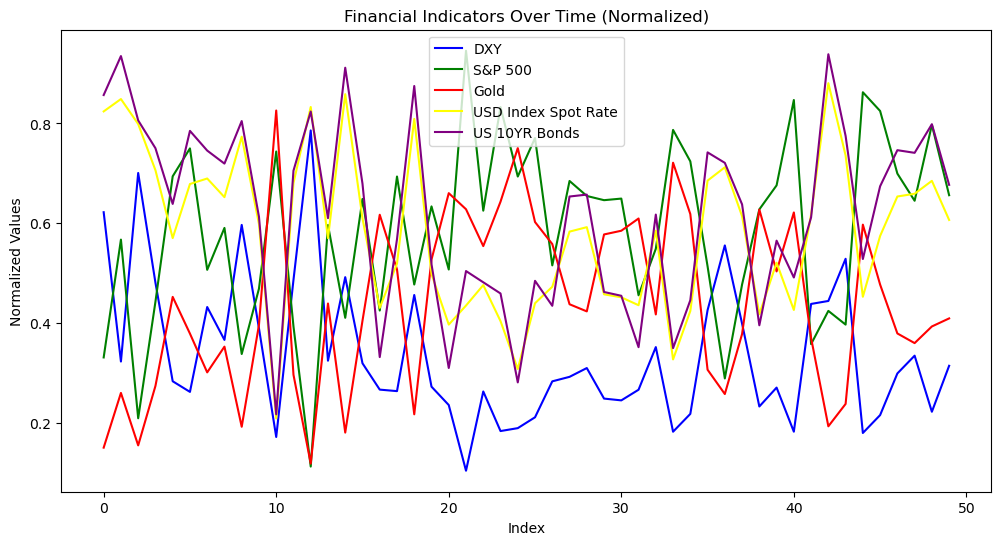

In [107]:
synthetic_df_scaled = (synthetic_df - synthetic_df.min()) / (synthetic_df.max() - synthetic_df.min())

plt.figure(figsize=(12, 6))

colors = ['blue', 'green', 'red', 'yellow', 'purple']
for col, color in zip(synthetic_df_scaled.columns, colors):
    plt.plot(synthetic_df_scaled.iloc[:50,].index, synthetic_df_scaled.iloc[:50,][col], label=col, color=color)

plt.xlabel('Index')
plt.ylabel('Normalized Values')
plt.title('Financial Indicators Over Time (Normalized)')
plt.legend()
plt.show()

In [118]:
synthetic_df_scaled

,DXY,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds
0,0.622363,0.331594,0.150984,0.824176,0.856968
1,0.323421,0.567504,0.260535,0.848965,0.934975
2,0.700901,0.209840,0.155540,0.798909,0.806133
3,0.481311,0.443132,0.274490,0.706489,0.750517
4,0.283913,0.694250,0.452831,0.570557,0.638969
...,...,...,...,...,...
9995,0.462738,0.381723,0.178950,0.903490,0.952268
9996,0.146722,0.809759,0.376747,0.770749,0.882481
9997,0.207727,0.760025,0.629106,0.415877,0.448539
9998,0.299439,0.635478,0.467029,0.549908,0.593240


<Axes: >

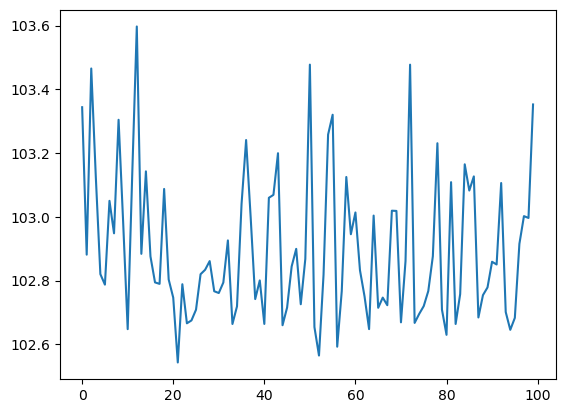

In [117]:
synthetic_df.iloc[:100,0].plot()

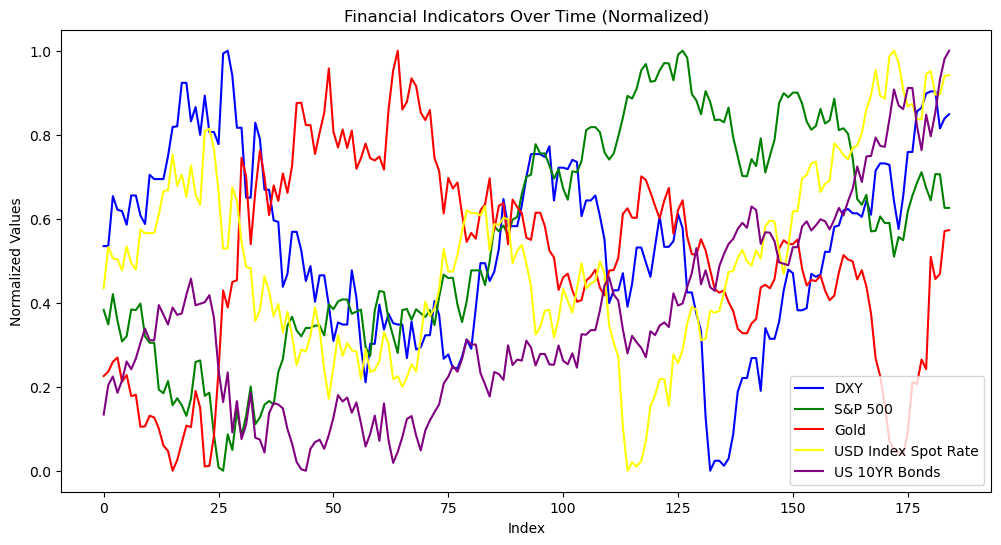

In [51]:
df_scaled = (df - df.min()) / (df.max() - df.min())

plt.figure(figsize=(12, 6))

# Plot each column with a unique color
colors = ['blue', 'green', 'red', 'yellow', 'purple']
for col, color in zip(df_scaled.columns, colors):
    plt.plot(df_scaled.index, df_scaled[col], label=col, color=color)

plt.xlabel('Index')
plt.ylabel('Normalized Values')
plt.title('Financial Indicators Over Time (Normalized)')
plt.legend()
plt.show()